In [0]:
from google.colab import drive
import h5py
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import gridspec
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
import tensorflow as tf
from tensorflow import keras

In [0]:
drive.mount('/content/drive')

In [0]:
# general path 
path = '/content/drive/My Drive/'
# data path with datasets names
data_path = 'Colab_data/'
data_name = 'XYdata_40k_3bb_testset.h5'

In [0]:
xy_h5f = h5py.File(path + data_path + data_name, 'r')

In [0]:
X_test = np.array(xy_h5f['X_test'])
Y_test = np.array(xy_h5f['Y_test'])
imgs_mean = np.array(xy_h5f['imgs_mean'])
imgs_std = np.array(xy_h5f['imgs_std'])

xy_h5f.close()

In [0]:
n_examples = X_test.shape[0]
side_dim = X_test.shape[1]
n_bb = Y_test.shape[1] // 6

print('Test examples:', X_test.shape[0])
print('Image size:', side_dim, 'x', side_dim)
print('Bounding boxes per image:', n_bb)
print('-------')
print('Images mean:', imgs_mean)
print('Images standard deviation:', imgs_std)

Test examples: 6000
Image size: 64 x 64
Bounding boxes per image: 3
-------
Images mean: 196.2765323384603
Images standard deviation: 18.37592427614397


In [0]:
classes = { 0: '--', 
            1: '+r',
            2: '+g',
            3: '+b',
            4: '#r',
            5: '#g',
            6: '#b',
            7: 'or',
            8: 'og',
            9: 'ob',
          }

In [0]:
# coordinates loss function
def rmse(y_true, y_pred):
  '''  
  Arguments:
  y_true -- tensor with expected Y
  y_pred -- tensor with predicted Y
  
  Returns:
  euc_dist -- scalar
  '''
  rmse = K.sqrt(K.mean(K.square(y_pred -y_true), axis=-1))
  return rmse

In [0]:
# model path with models names
model_path = 'Colab_models/'
model_name = 'DenseNet20134k_3bb_220_ep.h5' # 'VGG19_34k_3bb_130_ep.h5' # 'ResNet152V234k_3bb_200_ep.h5' #

In [155]:
# clear ghraph
tf.keras.backend.clear_session()
# load model
model = keras.models.load_model(path + model_path + model_name, custom_objects={'rmse': rmse})

In [0]:
model.summary()

## Make predictions


In [0]:
# Ppredictions from neural network using Test set as input
model_predictions = model.predict(X_test)

In [0]:
# decompose predictions by different targets (class, confidence, coordinates)
predict_class = model_predictions[0].reshape(n_examples, n_bb, -1)
predict_confidence = model_predictions[1].reshape(n_examples, -1, 1) / 2 + (1/2)
predict_bboxes = model_predictions[2].reshape(n_examples, n_bb, -1)              

## confidence Predictions

In [0]:
# now consider only the level of confidence
true_confidence = Y_test[:, 1::6].reshape(-1)
pred_confidence = predict_confidence.reshape(-1)

In [0]:
# now we consider the strictly and almost equivalence of confidence
src = (pred_confidence == true_confidence)
arc = (np.round(pred_confidence) == np.round(true_confidence))

strictly_right_confidence = np.count_nonzero(src)
almost_right_confidence = np.count_nonzero(arc)

# to see the confidence accuracy we just need the almost results
confidence_accuracy = almost_right_confidence / (n_examples*n_bb)
#strictly_confidence_accuracy = strictly_right_confidence / (n_examples*n_bb)

In [0]:
# let's create some mask
# obj not created, obj not to detect (non_obj), obj created
c_zero = (true_confidence == 0)
c_non_obj = (true_confidence == .1)
c_one = (true_confidence == 1)

# strictly obj confidence 
right_c_zero = np.count_nonzero(src * c_zero)
right_c_one = np.count_nonzero(src * c_one)

# almost obj confidence
almost_zero = np.count_nonzero(arc * c_zero) + np.count_nonzero(arc * c_non_obj)
almost_one = np.count_nonzero(arc * c_one)

# wrong confidence prediction
wrong_prediction = (n_examples*n_bb) - np.count_nonzero(arc)

# confidence original/predicted data
confidence_original_data = [c_zero, c_non_obj, c_one]

confidence_predicted_data= [right_c_zero,
                           almost_zero-right_c_zero, 
                           wrong_prediction,
                           almost_one-right_c_one,
                           right_c_one]

# confidence confusion matriz
y_true = true_confidence.astype('int16')
y_pred = np.round(pred_confidence).astype('int16')
confidence_confusion_matrix = confusion_matrix(y_true, y_pred)

In [0]:
# method to show some data about confidence results
def plot_confidence_data(confidence_original_data, 
                         confidence_predicted_data, 
                         confidence_confusion_matrix):
  """
  """
  # Plot true confidence distribution vs predict confidence distribution
  fig = plt.figure(figsize=(12,6))
  plt.title('obj confidence distribution')
  plt.axis('off')

  gs = gridspec.GridSpec(ncols=4, nrows=1, width_ratios=[5, 5, .4, 3]) 
  ax1 = fig.add_subplot(gs[0])
  ax2 = fig.add_subplot(gs[1])
  ax3 = fig.add_subplot(gs[3])

  # pie with objects above_pc_obj, below_pc_obj and no_obj
  ax1.set_title('Real objects distribution')
  explode = [0, .1, .1]
  ax1.pie([np.count_nonzero(confidence_original_data[0]), # c_zero 
          np.count_nonzero(confidence_original_data[1]), # c_non_obj 
          np.count_nonzero(confidence_original_data[2])], # c_one 
          autopct='%1.1f%%', explode=explode, colors=[[.7, .4, .8],[.7, .2, .6],[.8, .4, .2]])
  ax1.legend(['objects not created',
              'objects below Pc_th',
              'object above Pc_th'], loc = 'lower left')

  # pie with objects above_pc_obj, below_pc_obj and no_obj
  ax2.set_title('Predict objects distribution')
  explode = [.02, .02, .2, 0, 0]
  ax2.pie(confidence_predicted_data, 
          autopct='%1.1f%%', explode=explode, colors=[[.7, .6, .0],'y', 'r',[.0, .65, .0],'g'])
  ax2.legend(['right 0',
              'almost 0',
              'wrong', 
              'almost 1',
              'right 1'], loc = 'lower right')

  # confusion matrix
  ax3.set_title('Confusion matrix')

  cmap = ListedColormap(['r',[.7, .6, .0],'r','g'])
  ax3.imshow(confidence_confusion_matrix, cmap=cmap)
  ax3.set_xticks([0,1])
  ax3.set_xticklabels([0, 1])
  ax3.set_yticks([0,1])
  ax3.set_yticklabels([0, 1])
  for i in range(confidence_confusion_matrix.shape[0]):
    for j in range(confidence_confusion_matrix.shape[1]):
      ax3.text(j, i ,confidence_confusion_matrix[i,j], color='w', fontsize=14, horizontalalignment='center',)

  plt.show()

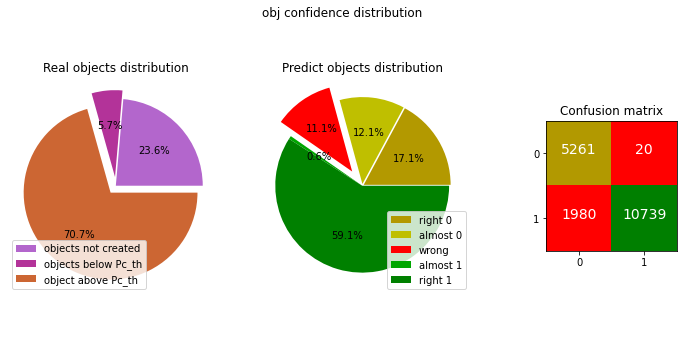

In [0]:
# MyAlexNet
plot_confidence_data(confidence_original_data, 
                         confidence_predicted_data, 
                         confidence_confusion_matrix)

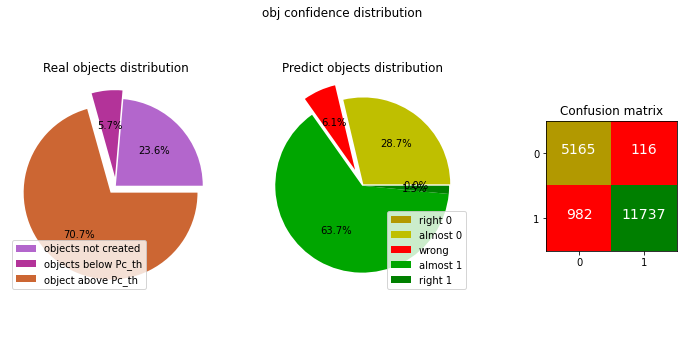

In [0]:
# Resnet152V2
plot_confidence_data(confidence_original_data, 
                         confidence_predicted_data, 
                         confidence_confusion_matrix)

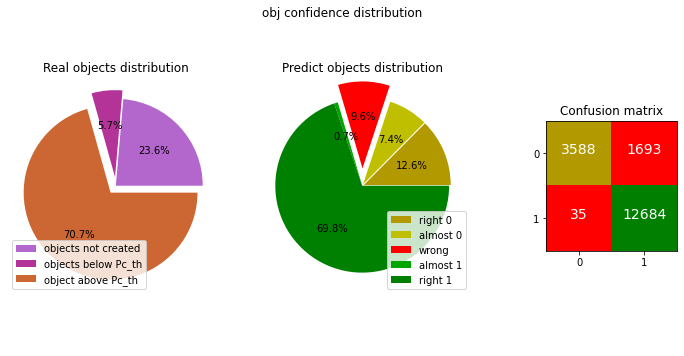

In [0]:
# VGG19
plot_confidence_data(confidence_original_data, 
                         confidence_predicted_data, 
                         confidence_confusion_matrix)

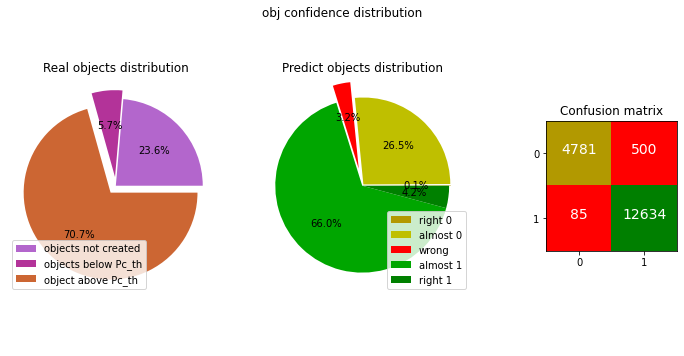

In [161]:
# DenseNet201
plot_confidence_data(confidence_original_data, 
                         confidence_predicted_data, 
                         confidence_confusion_matrix)

## Class predictions
Now let's evaluate the predictions regarding the classification of the different objects, remember that we have nine classes (red cross, green cross, blue cross, red pound, green pound, blue pound, red square, green square, blue square) plus a tenth in case of background (when we have no objects or the objects belong to the background and on the basis of our Pc_th they don't have to be classified)

classes = {0: '-', 1: '+ r', 2: '+ g', 3: '+ b', 4: '#r', 5: '#g', 6: '#b ', 7:' or ', 8:' og ', 9:' ob '}

In [162]:
# reshape and convert softmax data to class prediction  
predict_class = predict_class.argmax(-1).reshape(n_examples, n_bb, 1)

# shape of prediction for class, confidence and bboxes coordinates
predict_class.shape, predict_confidence.shape, predict_bboxes.shape

((6000, 3, 1), (6000, 3, 1), (6000, 3, 4))

In [0]:
true_class = Y_test[:, 0::6].reshape(-1).astype('int8')
pred_class = predict_class.reshape(-1).astype('int8') 

In [0]:
# Number of correctly classified objects (absolute and average value)
obj_to_identify = np.count_nonzero(true_class > 0)
obj_identified = np.count_nonzero((true_class == pred_class)*(true_class > 0))
nonobj_identified = np.count_nonzero((true_class == pred_class)*(true_class == 0))
overall_identification = np.count_nonzero(true_class == pred_class)

wrong_classification = np.count_nonzero(true_class != pred_class)
class_confusion_matrix = confusion_matrix(true_class, pred_class)

# Accuracy
accuracy_obj_identified = obj_identified / np.count_nonzero(true_class > 0)
accuracy_overall_identified = overall_identification / (n_examples*n_bb)

In [0]:
def plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix):
  cl = classes.values()
  ticks = np.arange(0,10)

  fig = plt.figure(figsize=(12,6))
  plt.axis('off')

  gs = gridspec.GridSpec(ncols=2, nrows=1, width_ratios=[2, 3]) 
  ax1 = fig.add_subplot(gs[0])
  ax2 = fig.add_subplot(gs[1])

  # Plot Histogram obj classes distribution
  bins = np.arange(0, 11, 1)
  ax1.hist([true_class, pred_class], bins=bins-0.5, color=('y','g'))
  ax1.set(title='obj real classes / predictions', xlabel='classes', ylabel='num examples')
  ax1.set_xticks(ticks=bins) #, label=list(classes.values()))
  ax1.legend(['Real class','Predicted class'])

  # confusion matrix
  ax2.set_title('Confusion matrix')

  cmap = 'cividis'
  ax2.imshow(class_confusion_matrix, cmap=cmap)
  ax2.set_xlabel('predicted classes')
  ax2.set_xticks(ticks)
  ax2.set_xticklabels(cl)
  ax2.set_ylabel('true classes')
  ax2.set_yticks(ticks)
  ax2.set_yticklabels(cl)
  for i in range(class_confusion_matrix.shape[0]):
    for j in range(class_confusion_matrix.shape[1]):
      ax2.text(j, i ,class_confusion_matrix[i,j], color=[.8,.4,.1], fontsize=10, horizontalalignment='center',)

  plt.show()

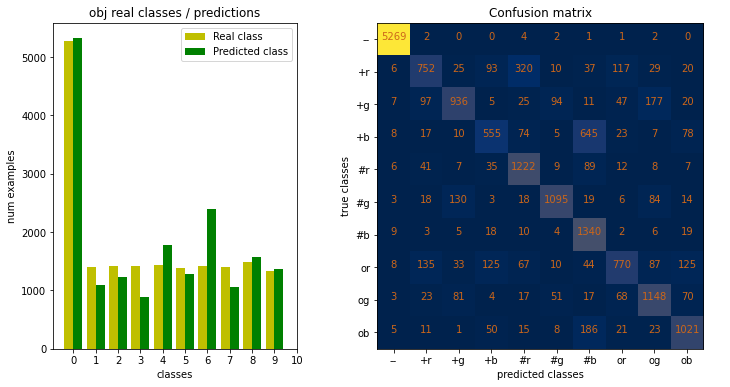

In [0]:
# MyAlexNet
plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix)

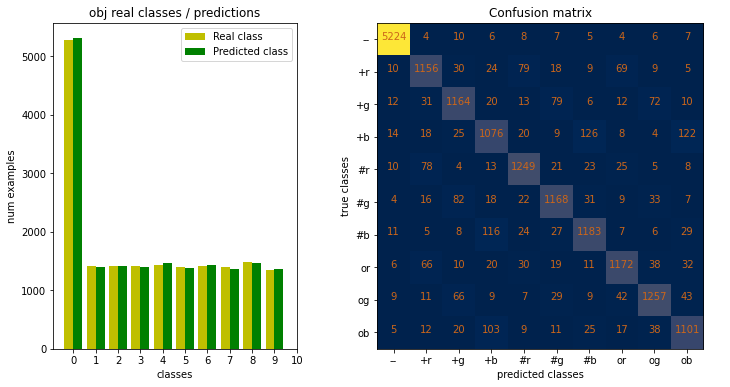

In [0]:
# Resnet152V2
plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix)

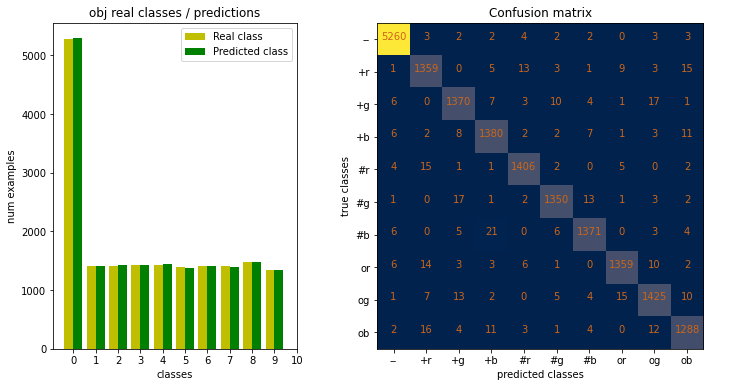

In [0]:
# VGG19
plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix)

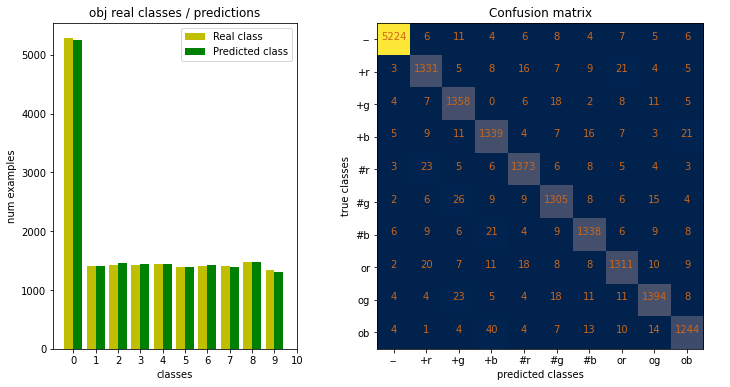

In [174]:
# DenseNet201
plot_cassification_data(classes, true_class, pred_class, class_confusion_matrix)

## Coordinates predictions

In [0]:
# Image decoding from normalized dataset
imgTest = ((np.reshape(X_test, (n_examples, side_dim, side_dim, 3)) * imgs_std) + imgs_mean)/255

In [166]:
# concatenate reshaped predictions
pred_bboxes = np.concatenate((predict_class, predict_confidence, predict_bboxes), 2)

# reshaped expected bboxes of our Validation set
expe_bboxes = Y_test.reshape(n_examples, n_bb, -1)

# check equivalence of their dimension
pred_bboxes.shape, expe_bboxes.shape

((6000, 3, 6), (6000, 3, 6))

In [0]:
def IoU(box1, box2):
  '''  
  Arguments:
  box1 -- first box, with coordinates (x, y, w, h)
  box2 -- second box, with coordinates (x2, y2, w2, h2)
  
  Returns:
  iou -- scalar
  '''    
  [x, y, w, h] = box1
  [x2, y2, w2, h2] = box2
  # Intesection area 
  xi1 = np.maximum(x, x2)
  yi1 = np.maximum(y, y2)
  xi2 = np.minimum(x+w, x2+w2)
  yi2 = np.minimum(y+h, y2+h2)
  xi = np.maximum(0., xi2-xi1)
  yi = np.maximum(0., yi2-yi1)
  
  inter_area = np.multiply(xi,yi)

  # Union area
  box1_area = (w*h)
  box2_area = (w2*h2)
  union_area = box1_area+box2_area-inter_area
  
  # Calculation of IoU
  iou = inter_area/union_area
  return iou

In [0]:
def visualize_predictions(n_visual, rand_examples, iou_tr, imgTest, pred_bboxes, expe_bboxes):
    '''
    Arguments:
    ax -- plot image
    img -- np.array(side_dim,side_dim,3), an image
    bboxes -- np.array(n_bb,6), predicted bounding boxes
    expe_bboxes -- np.array(n_bb,6), expected bounding boxes
    iou_tr -- scalar, IoU treshold

    Returns:
    None
    '''
    # image side dimension
    side_dim = imgTest.shape[1]

    # number of bounding boxes
    n_bb = pred_bboxes.shape[1]

    # show predictions
    fig = plt.figure(figsize=(18,8))
    for i in range (n_visual):
      
      # We take a random image of our training set
      im = rand_examples[i]
      ax = fig.add_subplot((n_visual//4)+1,4, i+1)
      ax.grid( which='both', color='w', linestyle=':')
      plt.xticks(np.arange(0, side_dim, step=10))
      ax.set_title('Imagine n.' + str(im))

      img = imgTest[im]
      pred = pred_bboxes[im]
      expe = expe_bboxes[im]

      # We look at the objects contained in it...
      ax.imshow(img, origin='upper', extent=[0, side_dim, side_dim, 0])

      # ...and the bounding boxes predicted by the algorithm
      print('_________________')
      print('Image', '{:5d}'.format(im))
      for j in range(n_bb):
          [Cl, Pc, x, y, w, h] = pred[j]
          Cl = classes[int(round(Cl))]
          
          [x2, y2, w2, h2] = expe[j, 2:]

          iou_bb = IoU([x, y, w, h], [x2, y2, w2, h2])
          if iou_bb >= iou_tr:
              rect = patches.Rectangle((x, y), w, h, ec='tab:red', lw='1.4', fc='none')
              dida = 'IoU: ' + '{:0.3f} '.format(iou_bb)
              plt.annotate(dida + Cl, (x + w, y + 0.8), color='tab:red')

          else:
              rect = patches.Rectangle((x, y), w, h, ec='tab:blue', lw='1.4', fc='none')

          ax.add_patch(rect)
          print('| Object class:', Cl, ',', 'Conf:', '{:+0.2f} '.format(Pc),
                '| Bounding Box IoU:', '{0:2.1%}'.format(iou_bb))
    plt.show()

In [0]:
# Internent over Union treshold to consider valid Bounding Boxes
iou_tr = .4

# We look at n_visual random images of our Validation set and at the bounding boxes predicted by the algorithm
n_visual = 3
rand_examples = np.random.randint(n_examples, size = (n_visual,))

In [0]:
rand_examples = [1700, 2732, 1736]

_________________
Image  1700
| Object class: #r , Conf: +0.00  | Bounding Box IoU: 33.0%
| Object class: #r , Conf: +1.00  | Bounding Box IoU: 74.8%
| Object class: +r , Conf: +1.00  | Bounding Box IoU: 52.1%
_________________
Image  2732
| Object class: #b , Conf: +1.00  | Bounding Box IoU: 60.9%
| Object class: #b , Conf: +1.00  | Bounding Box IoU: 23.9%
| Object class: -- , Conf: +0.00  | Bounding Box IoU: 0.0%
_________________
Image  1736
| Object class: #r , Conf: +0.00  | Bounding Box IoU: 65.0%
| Object class: og , Conf: +1.00  | Bounding Box IoU: 45.0%
| Object class: ob , Conf: +1.00  | Bounding Box IoU: 40.3%


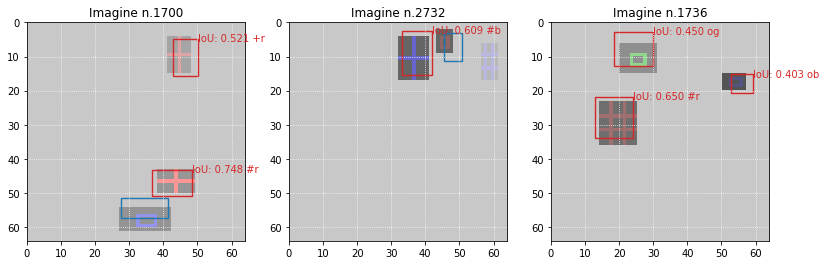

In [0]:
# MyAlexNet
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)

_________________
Image  1700
| Object class: or , Conf: +0.17  | Bounding Box IoU: 7.2%
| Object class: +r , Conf: +1.00  | Bounding Box IoU: 0.0%
| Object class: +r , Conf: +1.00  | Bounding Box IoU: 35.4%
_________________
Image  2732
| Object class: +b , Conf: +1.00  | Bounding Box IoU: 72.3%
| Object class: +b , Conf: +1.00  | Bounding Box IoU: 23.6%
| Object class: -- , Conf: +0.32  | Bounding Box IoU: 0.0%
_________________
Image  1736
| Object class: #r , Conf: +0.00  | Bounding Box IoU: 59.7%
| Object class: og , Conf: +1.00  | Bounding Box IoU: 43.9%
| Object class: ob , Conf: +1.00  | Bounding Box IoU: 60.1%


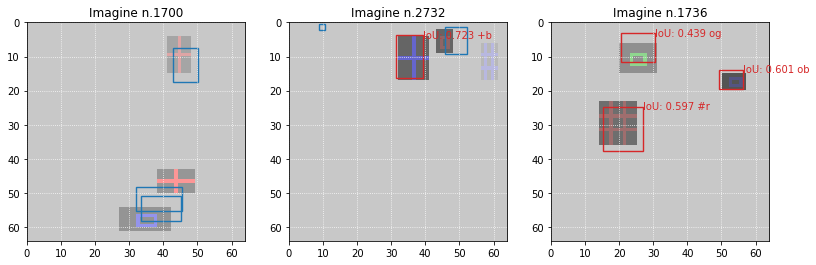

In [0]:
# Resnet152V2
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)


_________________
Image  1700
| Object class: ob , Conf: +1.00  | Bounding Box IoU: 84.0%
| Object class: +r , Conf: +1.00  | Bounding Box IoU: 72.8%
| Object class: +r , Conf: +1.00  | Bounding Box IoU: 74.5%
_________________
Image  2732
| Object class: +b , Conf: +1.00  | Bounding Box IoU: 65.4%
| Object class: or , Conf: +1.00  | Bounding Box IoU: 24.0%
| Object class: -- , Conf: +0.00  | Bounding Box IoU: 0.0%
_________________
Image  1736
| Object class: #r , Conf: +1.00  | Bounding Box IoU: 80.2%
| Object class: og , Conf: +1.00  | Bounding Box IoU: 77.0%
| Object class: ob , Conf: +1.00  | Bounding Box IoU: 59.1%


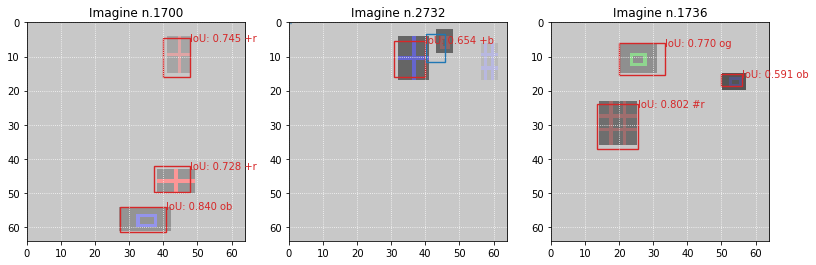

In [0]:
# VGG19
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)


_________________
Image  1700
| Object class: ob , Conf: +0.71  | Bounding Box IoU: 75.9%
| Object class: +r , Conf: +1.00  | Bounding Box IoU: 21.0%
| Object class: +r , Conf: +0.98  | Bounding Box IoU: 15.6%
_________________
Image  2732
| Object class: +b , Conf: +1.00  | Bounding Box IoU: 67.8%
| Object class: ob , Conf: +0.99  | Bounding Box IoU: 0.0%
| Object class: -- , Conf: +0.15  | Bounding Box IoU: 0.0%
_________________
Image  1736
| Object class: #r , Conf: +0.88  | Bounding Box IoU: 84.0%
| Object class: og , Conf: +1.00  | Bounding Box IoU: 59.5%
| Object class: ob , Conf: +0.99  | Bounding Box IoU: 66.9%


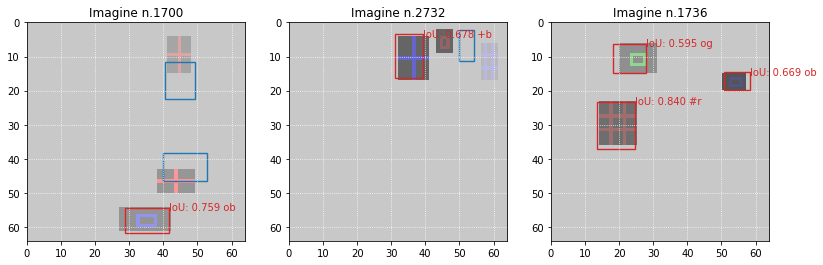

In [169]:
# DenseNet201
visualize_predictions(n_visual, rand_examples, iou_tr,
                      imgTest, 
                      pred_bboxes, expe_bboxes)

##Summarize the results obtained

In [0]:
# The average IoU of the whole dataset
def mean_IoU(expe_bboxes, pred_bboxes):
  '''  
  Arguments:
  expe_bboxes -- np.array(dim_test, n_bb, 5), expected bounding boxes 
  pred_bboxes -- np.array(dim_test, n_bb, 5), predicted bounding boxes 
  
  Returns:
  iou -- scalar, value of Intersection over Union of the whole dataset
  '''    
  
  [n_examples, n_bb] = expe_bboxes.shape[:2] 
  IoU_test = np.zeros((n_examples, n_bb)) 
  iou_global = 0

  for i in range(n_examples):
    for j in range(n_bb):

      [x , y, w, h] = pred_bboxes[i, j, 2:] 
      [x2, y2, w2, h2] = expe_bboxes[i, j, 2:] 

      IoU_test[i,j] = IoU([x,y,w,h], [x2,y2,w2,h2])

  iou_global = np.mean(IoU_test)
  return iou_global

In [0]:
# The average center of the object in bounding box accuracy of the whole dataset 
def accuracy_centre(expe_bboxes, pred_bboxes):
  '''  
  Arguments:
  expe_bboxes -- np.array(dim_test, N_bb, 5), expected bounding boxes 
  pred_bboxes -- np.array(dim_test, N_bb, 5), predicted bounding boxes 
  
  Returns:
  iou -- scalar, value of Intersection over Union of the whole dataset
  '''    
  
  [n_examples, n_bb] = expe_bboxes.shape[:2] 
  acc_test = np.zeros((n_examples, n_bb)) 
  acc_global = 0

  for i in range(n_examples):
    for j in range(n_bb):

      [x , y, w, h] = pred_bboxes[i, j, 2:] 
      [x2, y2, w2, h2] = expe_bboxes[i, j, 2:] 
      centreX = x+(w/2)
      centreY = y+(h/2)

      acc_test[i,j] = (x2 < centreX < x2+w2) and (y2 < centreY < y2+h2)

  acc_global = np.mean(acc_test)
  return acc_global

In [0]:
m_iou = mean_IoU(expe_bboxes, pred_bboxes)
m_acc = accuracy_centre(expe_bboxes, pred_bboxes)

In [0]:
# MyAlexNet 
print('Obj almost right confidence:', almost_right_confidence,'| accuracy:', confidence_accuracy, '\n')

print('Correct obj class identified:', obj_identified, 'on', (np.count_nonzero(true_class > 0)),
      ' |  accuracy:', accuracy_obj_identified)
print('Non-obj identified: ', nonobj_identified, 'on', (np.count_nonzero(true_class == 0)))
print('Overall class accuracy (considering non-obj):', accuracy_overall_identified, '\n')

print('Test-set mean IoU is:       ', m_iou)
print('Test-set mean xy-center Acc:', m_acc, '\n')

Obj almost right confidence: 16000 | accuracy: 0.8888888888888888 

Correct obj class identified: 8839 on 12719  |  accuracy: 0.6949445711140813
Non-obj identified:  5269 on 5281
Overall class accuracy (considering non-obj): 0.7837777777777778 

Test-set mean IoU is:        0.42846265340596285
Test-set mean xy-center Acc: 0.6532222222222223 



In [0]:
# Resnet152V2 
print('Obj almost right confidence:', almost_right_confidence,'| accuracy:', confidence_accuracy, '\n')

print('Correct obj class identified:', obj_identified, 'on', (np.count_nonzero(true_class > 0)),
      ' |  accuracy:', accuracy_obj_identified)
print('Non-obj identified: ', nonobj_identified, 'on', (np.count_nonzero(true_class == 0)))
print('Overall class accuracy (considering non-obj):', accuracy_overall_identified, '\n')

print('Test-set mean IoU is:       ', m_iou)
print('Test-set mean xy-center Acc:', m_acc, '\n')

Obj almost right confidence: 16902 | accuracy: 0.939 

Correct obj class identified: 10526 on 12719  |  accuracy: 0.8275807846528815
Non-obj identified:  5224 on 5281
Overall class accuracy (considering non-obj): 0.875 

Test-set mean IoU is:        0.4297183594105374
Test-set mean xy-center Acc: 0.6315555555555555 



In [0]:
# VGG19 
print('Obj almost right confidence:', almost_right_confidence,'| accuracy:', confidence_accuracy, '\n')

print('Correct obj class identified:', obj_identified, 'on', (np.count_nonzero(true_class > 0)),
      ' |  accuracy:', accuracy_obj_identified)
print('Non-obj identified: ', nonobj_identified, 'on', (np.count_nonzero(true_class == 0)))
print('Overall class accuracy (considering non-obj):', accuracy_overall_identified, '\n')

print('Test-set mean IoU is:       ', m_iou)
print('Test-set mean xy-center Acc:', m_acc, '\n')

Obj almost right confidence: 16272 | accuracy: 0.904 

Correct obj class identified: 12308 on 12719  |  accuracy: 0.9676861388473936
Non-obj identified:  5260 on 5281
Overall class accuracy (considering non-obj): 0.976 

Test-set mean IoU is:        0.4821958557581902
Test-set mean xy-center Acc: 0.6722777777777778 



In [173]:
# DenseNet201 
print('Obj almost right confidence:', almost_right_confidence,'| accuracy:', confidence_accuracy, '\n')

print('Correct obj class identified:', obj_identified, 'on', (np.count_nonzero(true_class > 0)),
      ' |  accuracy:', accuracy_obj_identified)
print('Non-obj identified: ', nonobj_identified, 'on', (np.count_nonzero(true_class == 0)))
print('Overall class accuracy (considering non-obj):', accuracy_overall_identified, '\n')

print('Test-set mean IoU is:       ', m_iou)
print('Test-set mean xy-center Acc:', m_acc, '\n')

Obj almost right confidence: 17415 | accuracy: 0.9675 

Correct obj class identified: 11993 on 12719  |  accuracy: 0.9429200408837173
Non-obj identified:  5224 on 5281
Overall class accuracy (considering non-obj): 0.9565 

Test-set mean IoU is:        0.48818929539969624
Test-set mean xy-center Acc: 0.6606666666666666 

